**This project is about taking what I learned in the "one author from title" notebook and applying it to the entire dataset, using the entire body of the text instead of just the title. I will still be using scikit-learn's TfidfVectorizer as my plaintext vectorizer in this project.**

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MinMaxScaler

First I read in the papers_and_authors csv.

In [2]:
papers_and_authors = pd.read_csv('E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/papers_and_authors.csv')
papers_and_authors.head()

,year,title,event_type,pdf_name,abstract,paper_text,paper_id,author_id
0,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1
1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54


Now, I am only dropping the pdf_name and abstract fields. The pdf name is redundant/useless information and the abstract field is incomplete and I'm not yet sure how to deal with it in the final analysis.

In [3]:
auth_text_len = papers_and_authors.drop(['pdf_name', 'abstract'], axis=1)
auth_text_len.head()

,year,title,event_type,paper_text,paper_id,author_id
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54


I want to add some additional features to my dataset, and the first one will be the length of the title. The first line checks the length of the title at position 0, the using .apply I create a new column with the title lengths as the values. Double checking the head confirms that my first title is 62 characters long.

In [4]:
print(len(auth_text_len.at[0, 'title']))

auth_text_len['title_len'] = auth_text_len.title.apply(lambda row: len(row))
auth_text_len.head()

62


,year,title,event_type,paper_text,paper_id,author_id,title_len
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116


The next step is doing this with total paper length. It's possible that word count would be better than character count, but for now I'll use this.

In [5]:
auth_text_len['paper_len'] = auth_text_len.paper_text.apply(lambda row: len(row))
auth_text_len.head()

,year,title,event_type,paper_text,paper_id,author_id,title_len,paper_len
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523


I also want a feature for average word length in the paper, below is a custom function that splits the body of the text into the individual words, then finds their average length. It takes a block of text, in this case the values from the paper_text column, as its only parameter.

Checking that this works on the first row of the data.

In [6]:
def avg_word_len(row):
    text_list = row.split()
    try:
        avg_len = sum(len(word) for word in text_list) / len(text_list)
        return avg_len
    except:
        return 0

In [7]:
avg_word_len(auth_text_len.paper_text[0])

4.8082635700783145

Now I'm applying this function across the entire dataset with lambda, and double checking that it correctly created a new column.

In [8]:
auth_text_len['avg_word_len'] = auth_text_len.paper_text.apply(lambda row: avg_word_len(row))
auth_text_len.head()

,year,title,event_type,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len
0,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264
1,1987,Self-Organization of Associative Database and ...,NaN,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264
2,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807
3,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861
4,1988,Storing Covariance by the Associative Long-Ter...,NaN,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861


I had 4 entries that had an average word length of 0. I drop them and double check that none remain.

In [9]:
print(auth_text_len.query('avg_word_len == 0'))

auth_text_len.drop(auth_text_len[auth_text_len['avg_word_len']==0].index, inplace=True)

print(auth_text_len.query('avg_word_len == 0'))

       year                                              title event_type  \
15924  2016  Regret Bounds for Non-decomposable Metrics wit...     Poster   
15925  2016  Regret Bounds for Non-decomposable Metrics wit...     Poster   
18546  2017  Mean Field Residual Networks: On the Edge of C...     Poster   
18547  2017  Mean Field Residual Networks: On the Edge of C...     Poster   

      paper_text  paper_id  author_id  title_len  paper_len  avg_word_len  
15924        6178       6597         62          9           0.0  
15925        6178       3906         62          9           0.0  
18546        6879       9809         50          9           0.0  
18547        6879      10122         50          9           0.0  
Empty DataFrame
Columns: [year, title, event_type, paper_text, paper_id, author_id, title_len, paper_len, avg_word_len]
Index: []


Now I fill the Nan's in the event_type column with Unknown, and drop the title column, as I only want text from the body of the paper right now. 

In [10]:
added_features = auth_text_len.fillna('Unknown')
added_features.drop(['title'], axis=1, inplace=True)
added_features.head()

,year,event_type,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len
0,1987,Unknown,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264
1,1987,Unknown,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264
2,1987,Unknown,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807
3,1988,Unknown,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861
4,1988,Unknown,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861


I use .get_dummies to change the categorical data from the event_type column to sparse numeric data, then join it to my dataframe and drop the old event_type column.

In [11]:
dummies = pd.get_dummies(added_features.event_type)
dummies.head()
added_dummies = added_features.join(dummies, how='outer')
added_dummies.drop(['event_type'], axis=1, inplace=True)
added_dummies.head()

,year,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown
0,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264,0,0,0,1
1,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264,0,0,0,1
2,1987,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807,0,0,0,1
3,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861,0,0,0,1
4,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861,0,0,0,1


Saving this dataframe for later

In [12]:
datapath = 'E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/added_features_data.csv'
added_dummies.to_csv(datapath, index=False)

Now I am using a custom function to check for Bernhard Scholkopf's author id (1472), and return a 1 if he wrote the paper and a 0 if he did not.

In [13]:
def bernhard_detector(row):
    if row['author_id'] == 1472:
        return 1
    else:
        return 0

Applying this custom function to the dataframe creates a new column with what will be my target feature, the is_bernhard column.

In [14]:
added_dummies['is_bernhard'] = added_dummies.apply(lambda row: bernhard_detector(row), axis=1)
added_dummies.head()

,year,paper_text,paper_id,author_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_bernhard
0,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,1,62,21643,4.808264,0,0,0,1,0
1,1987,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1,2,62,21643,4.808264,0,0,0,1,0
2,1987,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,10,14,98,15505,4.886807,0,0,0,1,0
3,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,155,116,20523,5.784861,0,0,0,1,0
4,1988,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,100,54,116,20523,5.784861,0,0,0,1,0


Now I can drop the author_id column, and in order to remove duplicate papers I sort Bernhard's papers to the top and use drop_duplicates with keep='first'. This creates a dataframe with 7239 entries, one for each unique paper. This is two less than the 7241 papers I initially had, because I removed the two papers with no paper text.

In [15]:
df = added_dummies.drop('author_id', axis=1)
df.sort_values(by='is_bernhard', ascending=False, inplace=True)
df.drop_duplicates(subset='paper_id', inplace=True, keep='first')
len(df)

7239

As expected, we have 62 entries for is_bernhard == 1.

In [16]:
len(df.query('is_bernhard == 1'))

62

A look at my final (pre vectorization) dataframe.

In [17]:
df.head()

,year,paper_text,paper_id,title_len,paper_len,avg_word_len,Oral,Poster,Spotlight,Unknown,is_bernhard
17276,2016,Consistent Kernel Mean Estimation\nfor Functio...,6545,67,33747,4.488406,0,1,0,0,1
7238,2008,Bayesian Experimental Design of Magnetic\nReso...,3558,68,33280,4.916890,0,0,0,1,1
1216,1998,Kernel peA and De-Noising in Feature Spaces\n\...,1491,43,22127,4.798472,0,0,0,1,1
1441,1998,Semiparametric Support Vector and\nLinear Prog...,1575,61,18571,4.874520,0,0,0,1,1
17038,2016,Minimax Estimation of Maximum Mean Discrepancy...,6483,66,29683,3.954461,0,1,0,0,1


Saving this dataframe so I can use it later

In [18]:
datapath = 'E:/OtherCodeProjects/Springboard Capstone Projects/Springboard-Capstone-1-Data/one_author_advanced_data.csv'
df.to_csv(datapath, index=False)

Now I split the features into X: my predictive features (excluding paper_id and is_bernhard), and y: the is_bernhard column flattened into a 1-D array.

In [19]:
exclude = ['paper_id', 'is_bernhard']
X = df[df.columns.difference(exclude)].reset_index(drop=True)

y = df['is_bernhard'].values.flatten()


I now need to scale the features in X so that they will work well with the Tfidf vectorized features. MinMaxScaler will scale the numbers to between 0 and 1, the same as the Tfidf vector

In [20]:
scaled_feat = X[X.columns.difference(['paper_text'])]
paper_text = pd.DataFrame(X.paper_text)

minmax = MinMaxScaler()
scaled_feat = pd.DataFrame(minmax.fit_transform(scaled_feat), columns=scaled_feat.columns)
X = scaled_feat.join(paper_text)
X

,Oral,Poster,Spotlight,Unknown,avg_word_len,paper_len,title_len,year,paper_text
0,0.0,1.0,0.0,0.0,0.409777,0.271676,0.410596,0.966667,Consistent Kernel Mean Estimation\nfor Functio...
1,0.0,0.0,0.0,1.0,0.477693,0.267896,0.417219,0.700000,Bayesian Experimental Design of Magnetic\nReso...
2,0.0,0.0,0.0,1.0,0.458923,0.177621,0.251656,0.366667,Kernel peA and De-Noising in Feature Spaces\n\...
3,0.0,0.0,0.0,1.0,0.470977,0.148838,0.370861,0.366667,Semiparametric Support Vector and\nLinear Prog...
4,0.0,1.0,0.0,0.0,0.325145,0.238781,0.403974,0.966667,Minimax Estimation of Maximum Mean Discrepancy...
...,...,...,...,...,...,...,...,...,...
7234,0.0,0.0,0.0,1.0,0.422588,0.281098,0.437086,0.700000,Linear Classification and Selective Sampling\n...
7235,0.0,0.0,0.0,1.0,0.510911,0.126619,0.324503,0.100000,Generalization Dynamics in\nLMS Trained Linear...
7236,0.0,0.0,0.0,1.0,0.436957,0.254209,0.430464,0.700000,MAS: a multiplicative approximation scheme for...
7237,0.0,0.0,0.0,1.0,0.443642,0.264076,0.198675,0.700000,Clustering via LP-based Stabilities\n\nNikos K...


Creating my train and test splits, with a train size of 75% and stratified on my target feature.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, train_size=0.75, stratify=y)

I will need to add the other features back in later, so I save them in sparse matrix form

In [23]:
other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

Now it's time to TfidfVectorize the paper text. I fit and transform on the train set and only transform the test set. Looking at the shape indicates that I now have 196,602 total features (mostly individual word n-grams).

In [24]:
tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

print(X_train_vector.shape)
print(X_test_vector.shape)

(5429, 196602)
(1810, 196602)


Adding back in the other features with hstack. They are the 8 additional features seen here.

In [25]:
X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

print(X_train.shape)
print(X_test.shape)

(5429, 196610)
(1810, 196610)


My initial model will again be a logistic regression with class weights of {0:1, 1:99}, so the model is penalized 99x for an incorrect attribution of a Bernhard paper. 

In [26]:
pipe1 = make_pipeline(LogisticRegression(random_state=21, class_weight={0:1, 1:99}, C=1))

I fit on the train data and predict on both the train and test data.

In [27]:
pipe1.fit(X_train, y_train)

pipe1_train_pred = pipe1.predict(X_train)
pipe1_test_pred = pipe1.predict(X_test)

This is the accuracy of the model on the train set. This is still quite high, and could represent overfitting, but I will cross validate later.

In [28]:
accuracy1_train = pipe1.score(X_train, y_train)
auc1_train = roc_auc_score(y_train, pipe1_train_pred)
recall1_train = recall_score(y_train, pipe1_train_pred)
precision1_train = precision_score(y_train, pipe1_train_pred)
print('Train Accuracy:', accuracy1_train)
print('Train AUC:', auc1_train)
print('Train Recall score:', recall1_train)
print('Train Precision score:', precision1_train)

Train Accuracy: 0.9937373365260638
Train AUC: 0.9968419097157718
Train Recall score: 1.0
Train Precision score: 0.575


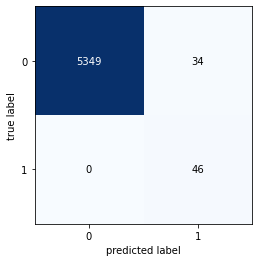

In [29]:
cm1_train = confusion_matrix(y_train, pipe1_train_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm1_train)
plt.show()

Here is the accuracy of the model on the test data, the performance is now better than on just titles, with an additional 3 papers predicted and fewer false positives.

In [30]:
accuracy1_test = pipe1.score(X_test, y_test)
auc1_test = roc_auc_score(y_test, pipe1_test_pred)
recall1_test = recall_score(y_test, pipe1_test_pred)
precision1_test = precision_score(y_test, pipe1_test_pred)
print('Test Accuracy:', accuracy1_test)
print('Test AUC:', auc1_test)
print('Test Recall score:', recall1_test)
print('Train Precision score:', precision1_test)

Test Accuracy: 0.9850828729281768
Test AUC: 0.6827619843924192
Test Recall score: 0.375
Train Precision score: 0.2608695652173913


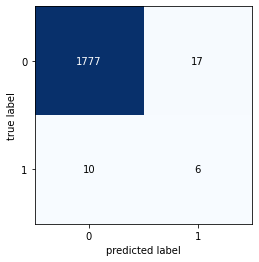

In [31]:
cm1_test = confusion_matrix(y_test, pipe1_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm1_test)
plt.show()

If there is overfitting, GridSearchCV can be used to cross validate and find the best value for C. I made a new pipeline with no random state for this.

In [32]:
pipe1_rand = make_pipeline(LogisticRegression(class_weight={0:1, 1:99}))

Checking what parameters I have available, right now I'm interested in 'logisticregression__C', as a potential fix for overfitting

In [33]:
pipe1_rand.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'logisticregression', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

The values of C I will test for the model

In [34]:
C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

Creating the grid search, with C as my only parameter I'm checking, and using roc_auc as my score

In [35]:
pipe1_rand_grid_cv = GridSearchCV(pipe1_rand, param_grid={'logisticregression__C':C}, cv=5, n_jobs=-1, scoring='roc_auc')

Fitting the grid search on my X_train and y_train data

In [36]:
pipe1_rand_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 99}))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001]},
             scoring='roc_auc')

The best roc_auc score of the models, lower than the AUC on pipe1 (0.997) but fairly high still

In [37]:
pipe1_rand_grid_cv.best_score_

0.9142441274257245

In [38]:
pipe1_rand_grid_cv.cv_results_['mean_test_score']

array([0.91424413, 0.90862546, 0.88854812, 0.86668752, 0.81921866,
       0.81325813, 0.81218039])

A C=1 was chosen, this could mean that there was no overfitting at all, but I'm not convinced given the huge discrepency between the train and test results.

In [39]:
pipe1_rand_grid_cv.best_params_

{'logisticregression__C': 1}

Picking out the best estimator I found, then predicting on the test set

In [40]:
pipe1_rand_best = pipe1_rand_grid_cv.best_estimator_

In [41]:
pipe1_grid_cv_test_pred = pipe1_rand_best.predict(X_test)

The results are identical to when I did this earlier, as I would expect.

In [42]:
accuracy1_grid_cv_test = pipe1_rand_best.score(X_test, y_test)
auc1_grid_cv_test = roc_auc_score(y_test, pipe1_grid_cv_test_pred)
recall1_grid_cv_test = recall_score(y_test, pipe1_grid_cv_test_pred)
precision1_grid_cv_test = precision_score(y_test, pipe1_grid_cv_test_pred)
print('Test Accuracy:', accuracy1_grid_cv_test)
print('Test AUC:', auc1_grid_cv_test)
print('Test Recall score:', recall1_grid_cv_test)
print('Train Precision score:', precision1_grid_cv_test)

Test Accuracy: 0.9850828729281768
Test AUC: 0.6827619843924192
Test Recall score: 0.375
Train Precision score: 0.2608695652173913


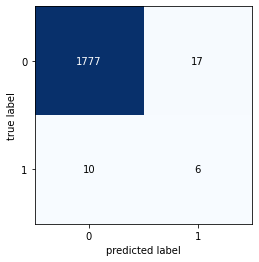

In [43]:
cm1_grid_cv_test = confusion_matrix(y_test, pipe1_grid_cv_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm1_grid_cv_test)
plt.show()

While GridSearchCV is an excellent tool, I want to see the results for each combination of possible hyperparameters myself, and help convince myself that no overfitting is going on. To that end the next notebook will involve a "manual grid search" where each combination of hyperparameters is checked in a for loop and the results are saved to a dictionary. The best model for a given metric can be found simply by sorting a dataframe of that dictionary.

One complicating factor is that the dataset is so imbalanced that different random states in the train_test splits can have a large impact on model performance. The code below is that same as the previous model except for a different random_state.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, train_size=0.75, stratify=y)

other_features_train = csr_matrix(X_train[X_train.columns.difference(['paper_text'])].values)
other_features_test = csr_matrix(X_test[X_test.columns.difference(['paper_text'])].values)

tfidf = TfidfVectorizer()

X_train_vector = tfidf.fit_transform(X_train.paper_text)
X_test_vector = tfidf.transform(X_test.paper_text)

X_train = hstack([other_features_train, X_train_vector])
X_test = hstack([other_features_test, X_test_vector])

In [53]:
pipe2 = make_pipeline(LogisticRegression(random_state=21, class_weight={0:1, 1:99}, C=1))

pipe2.fit(X_train, y_train)

pipe2_train_pred = pipe2.predict(X_train)
pipe2_test_pred = pipe2.predict(X_test)

The precision score is now almost 0.2 higher than it was previously, and the model predicted 3 additional papers. 

In [54]:
accuracy2_test = pipe2.score(X_test, y_test)
auc2_test = roc_auc_score(y_test, pipe2_test_pred)
recall2_test = recall_score(y_test, pipe2_test_pred)
precision2_test = precision_score(y_test, pipe2_test_pred)
print('Test Accuracy:', accuracy2_test)
print('Test AUC:', auc2_test)
print('Test Recall score:', recall2_test)
print('Train Precision score:', precision2_test)

Test Accuracy: 0.9895027624309393
Test AUC: 0.7779055183946488
Test Recall score: 0.5625
Train Precision score: 0.42857142857142855


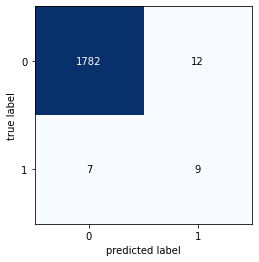

In [55]:
cm2_test = confusion_matrix(y_test, pipe2_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm2_test)
plt.show()

This means that cross validating is especially important to account for individual papers being left in or out of the training set. The models in the next notebook will have to be cross validated across different train_test random states in order to get a true idea of model performance.